### Problem from UW ME 525 - Applied Acoustics

<b>Arnie Larson</b>

In this exaple we investigate characterizing the noise level for a ship using a standard measurement technique.

After reading about a specification for measuring vessel noise level with a system using 3 hydrophones, we do a simplified analysis with a single hydrophone.

The experimental set up is repeated N times and the data has been curated into nice 1 second time series windows with $f_s = 96 \;kHz$.  It is appropriate here to take N samples and average them together to calculate a "better" source level for the example test.  

### Discussion

The codes to reproduce all of the plots and analysis are all below.

- For the NL calculation I remove the mean and apply a Hann window.  I then normalize the energy to that of the un windowed time series.
- I validate the total energy in the series in time domain and in frequency domain after windowing.
- For Fourier Transforms I do not do any zero padding since 1Hz resolution seems likely to be sufficient unless I expect something of interest below say 10 Hz.
- For averaging time series I take the mean of the PSD before calculating dB re 1uPa^2 / Hz
- Plots are generated for Noise Level (NL)
- Plots are generated for Receive Level (RL)
- Plots are generated for SNR = RL - NL
- A cutoff frequency of $f_c \approx 107\; Hz$ from the SNR plot shows where we are confident we can discern sound above the NL.  For plots and calculations of SL this we only utilize RL at $f_c$ or above.
- Plots are generated for the Source Level, SL = RL + TL
- Transmission Loss, $TL = 20 log_{10}(d) $ is around 40-42 dB for the distances given for the RL.
- The broadband SL is found to by integrating the SPL.  Broadband SL = 171.8 db re 1uPa^2 at 1m


### Attenutation

Is it appropriate to ignore attenuation for this test?   At 1kHz the attenuation approaches 0.05 dB/km and at 10kHz the attenuation is between 0.5 dB/km and 1 dB/km.  For the distances our measurements are taken (approx 150m) this will yield relatively small attenuation, especially at the lower frequencies and approaching 0.1 dB at the highest frequencies of interest.  Since the majority of the SPL arises from frequencies well below 10kHz, ignoring attenutation is probably good for estimates to within 0.1 dB.


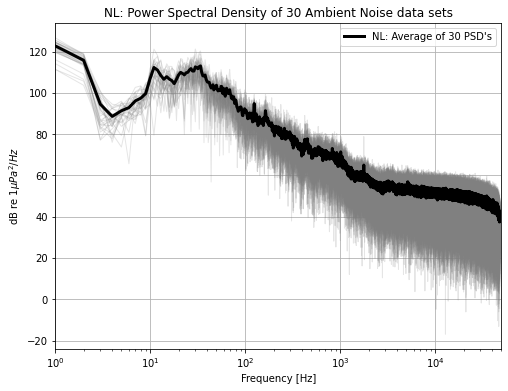

In [8]:
plot_ambient_psd()

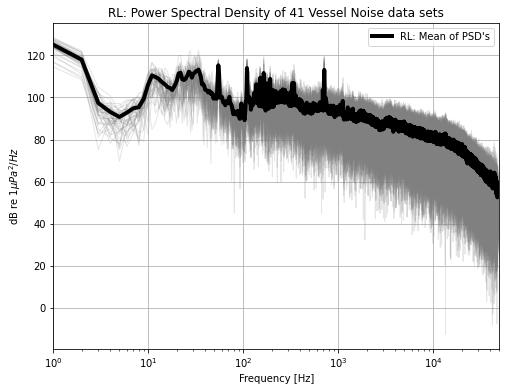

In [9]:
plot_vessel_noise()

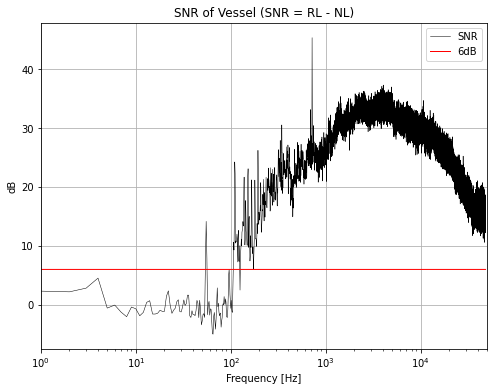

In [10]:
plot_snr()

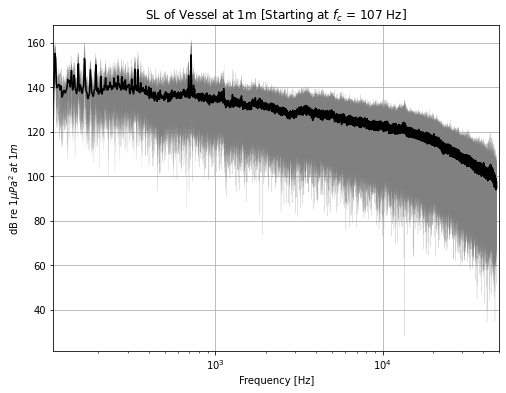

In [139]:
plot_sl()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy import signal
import scipy.io as io
import os

In [2]:
#=========================================================
#
#  Processing Script to load and normalize ambient.csv
#
#=========================================================

# Load csv data (each column is a time series, each row is data (in Pa))
ambient="data/ME525/PS6/Ambient-2.csv"
p1=np.genfromtxt(os.path.join(os.getcwd(),ambient), delimiter=",",dtype=np.float32)
# Remove mean
p2 = p1 - p1.mean(axis=0)
# Set up time domain
# look at the plots of the pressure  (these are each 1 Second windows, each with 96k samples)
T=1; fs = 96000;  DT= 1/fs;  Ns = 96000;
t=np.linspace(0,T-1/fs, Ns)

# Calculate energy in time domain
# what is time energy for the first few?
E2=(p2*p2).sum(axis=0)*DT
print("Energy, raw:  {} [Pa^2]".format(E2[:5]))

# Apply a Hann window**, will change the power by about sqrt(8/3)
w1=(0.5-0.5*np.cos(2*np.pi*t))   # appears to be same as w2 = signal.windows.hann(N)
p3=np.zeros_like(p2)
for col in range(p2.shape[1]):
    p3[:,col]=w1*p2[:,col]
E3=(p3*p3).sum(axis=0)*DT

# renormalize energy
for col in range(p3.shape[1]):
    p3[:,col]=np.sqrt(E2[col]/E3[col])*p3[:,col]
    
# recalculate energies
E3=(p3*p3).sum(axis=0)*DT
print("Energy, windowed: {} [Pa^2]".format(E3[:5]))

Energy, raw:  [7.340644  3.8824215 2.5099812 4.217944  4.415677 ] [Pa^2]
Energy, windowed: [7.340489  3.8824766 2.510027  4.2179646 4.41565  ] [Pa^2]


Energy in PSD (raw): 6.9587 [Pa^2]
Energy in PSD (windowed): 6.9588 [Pa^2]
Energy in raw at index 5: 6.9585 [Pa^2]


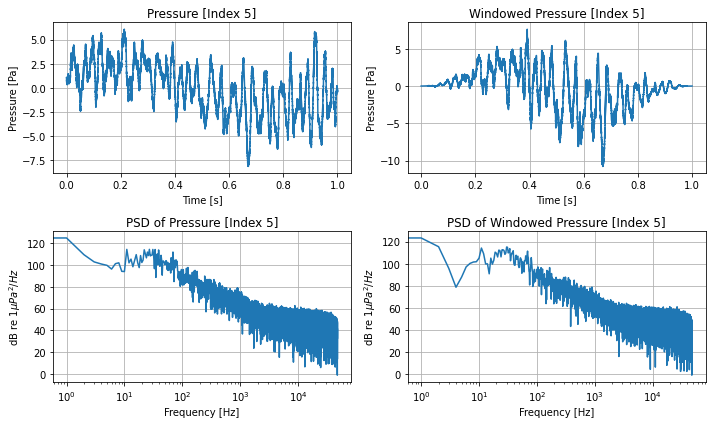

In [124]:
#=========================================================
#
#  Comparison of data, PSDs and energies for ambient.csv 
#  with/without Hann windowing applied
#
#=========================================================

N=t.shape[0]; DF=1;  # Series is 1 second, so DF is 1/T = 1Hz
idx=5                                     # random index
F2=np.abs(fft(p2[:,idx]))/N               # fourier spectrum of raw
F3=np.abs(fft(p3[:,idx]))/N               # fourier spectrum of windowed
f=fftfreq(N, DT)[:N//2] 
PSD2=2*F2[0:N//2]*F2[0:N//2]              # should remove half of the DC energy
PSD2[0]=PSD2[0]/2
print("Energy in PSD (raw): {:.4f} [Pa^2]".format(PSD2.sum()*DF))
PSD_db2 = 10*np.log10(PSD2/(1e-6)**2)
PSD3=2*F3[0:N//2]*F3[0:N//2]      # should remove half of the DC energy
PSD3[0]=PSD3[0]/2
print("Energy in PSD (windowed): {:.4f} [Pa^2]".format(PSD3.sum()*DF))
print("Energy in raw at index {}: {:.4f} [Pa^2]".format(idx, E2[idx]))
PSD_db3 = 10*np.log10(PSD3/(1e-6)**2)

fig, ax = plt.subplots(2,2,figsize=(10,6))
ax[0,0].plot(t,p2[:,0]); ax[0,0].set_xlabel("Time [s]")
ax[0,1].plot(t,p3[:,0]); ax[0,1].set_xlabel("Time [s]")
ax[0,0].set_title("Pressure [Index 5]"); ax[0,1].set_title("Windowed Pressure [Index 5]")
ax[0,0].set_ylabel("Pressure [Pa]"); ax[0,1].set_ylabel("Pressure [Pa]");
ax[1,0].semilogx(f, PSD_db2); ax[1,0].set_xlabel("Frequency [Hz]")
ax[1,1].semilogx(f, PSD_db3); ax[1,1].set_xlabel("Frequency [Hz]")
ax[1,0].set_title("PSD of Pressure [Index 5]"); ax[1,1].set_title("PSD of Windowed Pressure [Index 5]")
ax[1,0].set_ylabel("dB re $ 1 \mu Pa^2/ Hz$"); ax[1,1].set_ylabel("dB re $ 1 \mu Pa^2/ Hz$")
ax[0,0].grid(); ax[0,1].grid();
ax[1,1].grid(); ax[1,0].grid();
fig.tight_layout()
plt.show()

In [3]:
#=========================================================
#
#  Processing Script to calculate and plot PSD's for ambient.csv
#
#=========================================================

 
N=t.shape[0]; DT2 = t[1] - t[0]; DF=1;  # Series is 1 second, so DF is 1/T = 1Hz
# Try zero padding?  N=5*N   # consider trying to add zero padding
F=np.abs(fft(p3, axis=0))/N  # does FT across each column
f=fftfreq(N, DT)[:N//2]      # compute frequencies
psd=2*F[0:N//2,:]*F[0:N//2,:]            
psddb=10*np.log10(psd/(1e-6)**2)

# compute average 
psd_sum=psd.sum(axis=1)/psd.shape[1]
psd_sum_db=10*np.log10(psd_sum/(1e-6)**2)

# todo - generate function to create this plot
def plot_ambient_psd():
    plt.subplots(figsize=(8,6))

    plt.semilogx(f, psddb, color='grey', linewidth=1.0,alpha=0.2)
    plt.semilogx(f, psd_sum_db, color='black', label='NL: Average of 30 PSD\'s', linewidth=3.0)
    plt.title("NL: Power Spectral Density of 30 Ambient Noise data sets")
    plt.xlabel("Frequency [Hz]"); plt.ylabel("dB re $ 1 \mu Pa^2/ Hz$")
    plt.xlim(1,50000)
    plt.grid(); plt.legend()
    plt.show()
    #plt.savefig("ambient-testplot.pdf")

In [4]:
#=========================================================
#
#  Processing Script to load and normalize vesselnoisetimeseries.csv
#
#=========================================================

# Load data
vessel="data/ME525/PS6/VesselNoiseTimeseries.csv"
pv1=np.genfromtxt(os.path.join(os.getcwd(),vessel), delimiter=",",dtype=np.float32)

# Remove mean
pv2 = pv1 - pv1.mean(axis=0)
# Time Domain (1S, 96000 points already created)

# Calculate energy in time domain
# what is time energy for the first few?
EV2=(pv2*pv2).sum(axis=0)*DT
print("{} [Pa]".format(EV2[:5]))

# Apply a Hann window**, will change the power by about sqrt(8/3)
pv3=np.zeros_like(pv2)
for col in range(pv2.shape[1]):
    pv3[:,col]=w1*pv2[:,col]
EV3=(pv3*pv3).sum(axis=0)*DT

# renormalize energy
for col in range(pv3.shape[1]):
    pv3[:,col]=np.sqrt(EV2[col]/EV3[col])*pv3[:,col]
    
# recalculate energies
EV3=(pv3*pv3).sum(axis=0)*DT
print("{} [Pa]".format(EV3[:5]))

[ 9.409599 12.733634 16.766972 18.85019  20.787874] [Pa]
[ 9.409809 12.733665 16.767134 18.850697 20.788465] [Pa]


In [5]:
#=========================================================
#
#  Processing Script to calculate and plot PSD's for vessel noise
#
#=========================================================

 
N=t.shape[0]; DT2 = t[1] - t[0]; DF=1;  # Series is 1 second, so DF is 1/T = 1Hz
# Try zero padding?  N=5*N   # consider trying to add zero padding
Fv=np.abs(fft(pv3, axis=0))/N  # does FT across each column
fv=fftfreq(N, DT)[:N//2]      # compute frequencies
psdv=2*Fv[0:N//2,:]*Fv[0:N//2,:]            
psdvdb=10*np.log10(psdv/(1e-6)**2)

# compute average 
psdv_sum=psdv.sum(axis=1)/psdv.shape[1]
psdv_sum_db=10*np.log10(psdv_sum/(1e-6)**2)

# todo - generate function to create this plot
def plot_vessel_noise():
    plt.subplots(figsize=(8,6))
    plt.semilogx(f, psdvdb, color='grey', linewidth=1.0,alpha=0.2)
    plt.semilogx(f, psdv_sum_db, color='black', label='RL: Mean of PSD\'s', linewidth=4.0)
    plt.title("RL: Power Spectral Density of 41 Vessel Noise data sets")
    plt.xlabel("Frequency [Hz]"); plt.ylabel("dB re $ 1 \mu Pa^2/ Hz$")
    plt.xlim(1,50000)
    plt.grid(); plt.legend()
    plt.show()
#plt.savefig("ambient-testplot.pdf")

In [6]:
#=========================================================
#
#  SNR = RL - NL
#
#=========================================================

# just look at the mean value for a simple plot
# RL:  psdv is vessel noise 
# NL:  psd is ambient noise
psd_snr_db = psdv_sum_db - psd_sum_db

# todo - generate function to create this plot
def plot_snr():
    sixDb = np.ones(f.shape[0])*6
    plt.subplots(figsize=(8,6))
    plt.semilogx(f, psd_snr_db, color='black', label='SNR', linewidth=0.5)
    plt.semilogx(f, sixDb, color='red', label='6dB', linewidth=1.0)
    plt.title("SNR of Vessel (SNR = RL - NL)")
    plt.xlabel("Frequency [Hz]"); plt.ylabel("dB")
    plt.xlim(1,50000); plt.legend();
    plt.grid()
    plt.show()

In [7]:
# Note that at f >= 107 we are above the 6dB threshold
psd_snr_db[105:115]

array([ 1.89524945,  5.8236468 , 10.62521066,  9.29619824, 15.00269513,
       24.27159188, 22.2701825 , 10.47589018, 10.85332976, 10.65260633])

In [51]:
f[107]

107.0

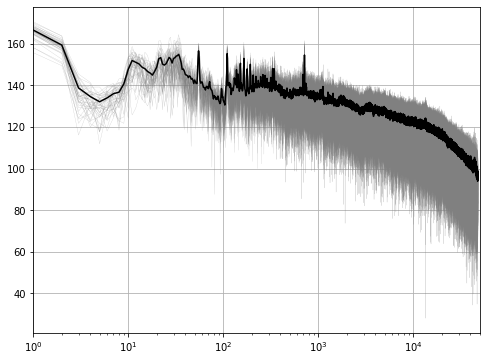

In [79]:
#=========================================================
#
#  SL = RL + TL
#  TL = 20 log (d)
#  d = sqrt( h**2 + r**2)
#
#=========================================================

# Load distance data
vesselrange="data/ME525/PS6/VesselRange.csv"
dv=np.genfromtxt(os.path.join(os.getcwd(),vesselrange), delimiter=",",dtype=np.float32)

h=50
d = np.sqrt(dv**2 + h**2)

TL = 20*np.log10(d)
SLdb = psdvdb + TL
PSDSL = (1e-12)*np.power(10,SLdb/10)

PSDSL_mean = PSDSL.sum(axis=1)/PSDSL.shape[1]
SL_mean_db = 10*np.log10(PSDSL_mean/(1e-12))

plt.subplots(figsize=(8,6))
plt.semilogx(f, SLdb, color='grey', linewidth=0.3, alpha=0.4)
plt.semilogx(f, SL_mean_db, color='black', linewidth=1.5)
plt.xlim(1,50000)
plt.grid()
plt.show()

In [138]:
#=========================================================
#
#  SL = RL + TL 
#  Implicitly is an integrated PSD, SPL in 1Hz bands
#
#=========================================================

def plot_sl():
    plt.subplots(figsize=(8,6))
    plt.semilogx(f[107:], SLdb[107:,:], color='grey', linewidth=0.3, alpha=0.4)
    plt.semilogx(f[107:], SL_mean_db[107:], color='black', linewidth=1.5)
    plt.title("SL of Vessel at 1m [Starting at $f_c$ = 107 Hz]")
    plt.xlabel("Frequency [Hz]"); plt.ylabel("dB re $ 1 \mu Pa^2 \; at \; 1m$")

    plt.xlim(107,50000)
    plt.grid()
    plt.show()

In [88]:
#=========================================================
#
#  Broadband SPL of source
#
#=========================================================

df=1   # 1Hz is the spectral resolution of the SPL plot above (same as the PSD plots)
integrated_spl = PSDSL_mean[107:].sum()*df
SPL = 10*np.log10(integrated_spl/(1e-12))
print("Integrated broadband SPL: {:.3f} dB re uPa^2 at 1m".format(SPL))

Integrated broadband SPL: 171.814 dB re uPa^2 at 1m


In [89]:
integrated_spl_1k = PSDSL_mean[107:1000].sum()*df
SPL_1k = 10*np.log10(integrated_spl_1k/(1e-12))
print("Integrated broadband SPL: {:.3f} dB re uPa^2 at 1m".format(SPL_1k))

Integrated broadband SPL: 169.090 dB re uPa^2 at 1m
